# Binary testing

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from infer_ci import MetricEvaluator
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from infer_ci.binary_metrics import accuracy_score_binomial_ci

In [2]:
df = load_breast_cancer(as_frame=True).frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.shape

(569, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
df.isnull().sum().sum()

np.int64(0)

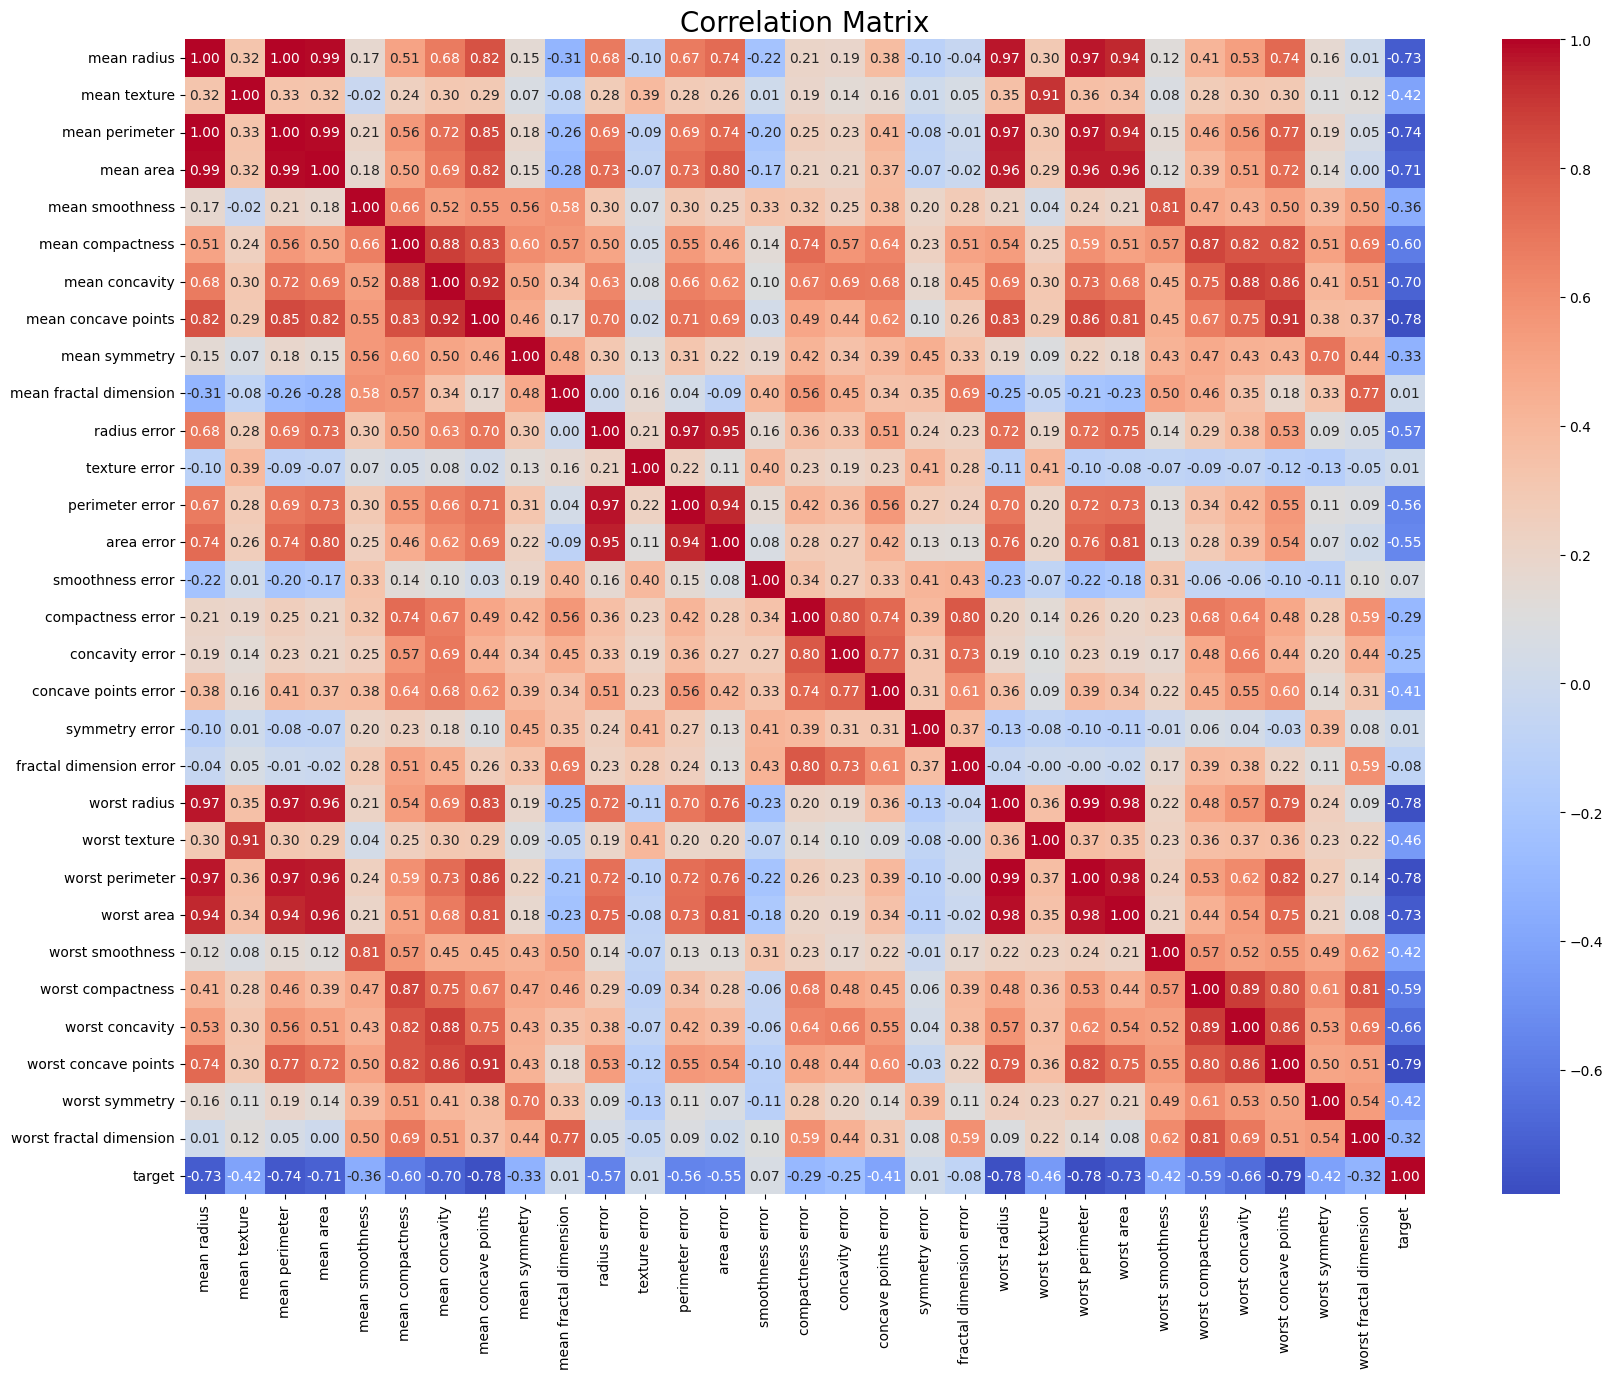

In [6]:
corr_m = df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_m, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

In [7]:
df.columns.to_list()

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension',
 'target']

In [8]:
df1 = corr_m.index[abs(corr_m['target']) > 0.5].to_list()
df1.remove('target')
print(df1)

['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [9]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [10]:
y = df['target']
x = df[df1]

print(f"Features used: {len(df1)}")
print(f"Total samples: {len(y)}")
print(f"Class distribution:")
print(y.value_counts())

Features used: 15
Total samples: 569
Class distribution:
target
1    357
0    212
Name: count, dtype: int64


# Binary Classification CI Validation

In [ ]:
# Single Experiment CI Validation

metrics = ['accuracy', 'precision', 'recall', 'f1']
evaluate = MetricEvaluator()

# Single experiment with fixed random state
random_state = 42
x_train_exp, x_temp, y_train_exp, y_temp = train_test_split(x, y, test_size=0.5, random_state=random_state)
x_test_exp, x_val_exp, y_test_exp, y_val_exp = train_test_split(x_temp, y_temp, test_size=0.8, random_state=random_state)

print(f"Data splits:")
print(f"Train: {len(x_train_exp)} samples")
print(f"Test: {len(x_test_exp)} samples")
print(f"Validation: {len(x_val_exp)} samples")
print()

# Scale features for logistic regression
scaler_exp = StandardScaler()
x_train_scaled = scaler_exp.fit_transform(x_train_exp)
x_test_scaled = scaler_exp.transform(x_test_exp)
x_val_scaled = scaler_exp.transform(x_val_exp)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=random_state, max_iter=1000)
lr_model.fit(x_train_scaled, y_train_exp)
y_test_pred_lr = lr_model.predict(x_test_scaled)
y_val_pred_lr = lr_model.predict(x_val_scaled)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    random_state=random_state
)
xgb_model.fit(x_train_exp, y_train_exp)
y_test_pred_xgb = xgb_model.predict(x_test_exp)
y_val_pred_xgb = xgb_model.predict(x_val_exp)

print("Models trained successfully!")
print()

# Evaluate each metric for both models
results = {}

for metric in metrics:
    print(f"=== {metric.upper()} METRIC ===")

    # Logistic Regression
    lr_result = evaluate.evaluate(y_true=y_test_exp, y_pred=y_test_pred_lr, task='classification', metric=metric)
    lr_test_value, (lr_ci_lower, lr_ci_upper) = lr_result

    if metric == 'accuracy':
        lr_val_value = evaluate.accuracy_score(y_val_exp, y_val_pred_lr, compute_ci=False)
    elif metric == 'precision':
        lr_val_value = evaluate.ppv_score(y_val_exp, y_val_pred_lr, compute_ci=False)
    elif metric == 'recall':
        lr_val_value = evaluate.tpr_score(y_val_exp, y_val_pred_lr, compute_ci=False)
    elif metric == 'f1':
        precision = evaluate.ppv_score(y_val_exp, y_val_pred_lr, compute_ci=False)
        recall = evaluate.tpr_score(y_val_exp, y_val_pred_lr, compute_ci=False)
        lr_val_value = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    lr_coverage = lr_ci_lower <= lr_val_value <= lr_ci_upper

    print(f"Logistic Regression:")
    print(f"  Test {metric}: {lr_test_value:.4f}")
    print(f"  Bootstrap CI: [{lr_ci_lower:.4f}, {lr_ci_upper:.4f}]")
    print(f"  Validation {metric}: {lr_val_value:.4f}")
    print(f"  CI Contains Validation: {lr_coverage}")
    print()

    # XGBoost
    xgb_result = evaluate.evaluate(y_true=y_test_exp, y_pred=y_test_pred_xgb, task='classification', metric=metric)
    xgb_test_value, (xgb_ci_lower, xgb_ci_upper) = xgb_result

    if metric == 'accuracy':
        xgb_val_value = evaluate.accuracy_score(y_val_exp, y_val_pred_xgb, compute_ci=False)
    elif metric == 'precision':
        xgb_val_value = evaluate.ppv_score(y_val_exp, y_val_pred_xgb, compute_ci=False)
    elif metric == 'recall':
        xgb_val_value = evaluate.tpr_score(y_val_exp, y_val_pred_xgb, compute_ci=False)
    elif metric == 'f1':
        precision = evaluate.ppv_score(y_val_exp, y_val_pred_xgb, compute_ci=False)
        recall = evaluate.tpr_score(y_val_exp, y_val_pred_xgb, compute_ci=False)
        xgb_val_value = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    xgb_coverage = xgb_ci_lower <= xgb_val_value <= xgb_ci_upper

    print(f"XGBoost:")
    print(f"  Test {metric}: {xgb_test_value:.4f}")
    print(f"  Bootstrap CI: [{xgb_ci_lower:.4f}, {xgb_ci_upper:.4f}]")
    print(f"  Validation {metric}: {xgb_val_value:.4f}")
    print(f"  CI Contains Validation: {xgb_coverage}")
    print()

    # Store results
    results[metric] = {
        'lr_coverage': lr_coverage,
        'xgb_coverage': xgb_coverage
    }

print("=== SUMMARY ===")
for metric in metrics:
    lr_coverage = results[metric]['lr_coverage']
    xgb_coverage = results[metric]['xgb_coverage']
    print(f"{metric.upper()}: LR={lr_coverage}, XGB={xgb_coverage}")

Data splits:
Train: 284 samples
Test: 57 samples
Validation: 228 samples

Models trained successfully!

=== ACCURACY METRIC ===
Models trained successfully!

=== ACCURACY METRIC ===
Logistic Regression:
  Test accuracy: 0.9298
  Bootstrap CI: [0.8421, 0.9825]
  Validation accuracy: 0.9474
  CI Contains Validation: True

Logistic Regression:
  Test accuracy: 0.9298
  Bootstrap CI: [0.8421, 0.9825]
  Validation accuracy: 0.9474
  CI Contains Validation: True

XGBoost:
  Test accuracy: 0.9649
  Bootstrap CI: [0.8772, 1.0000]
  Validation accuracy: 0.9342
  CI Contains Validation: True

=== PRECISION METRIC ===
XGBoost:
  Test accuracy: 0.9649
  Bootstrap CI: [0.8772, 1.0000]
  Validation accuracy: 0.9342
  CI Contains Validation: True

=== PRECISION METRIC ===
Logistic Regression:
  Test precision: 0.9394
  Bootstrap CI: [0.8000, 1.0000]
  Validation precision: 0.9671
  CI Contains Validation: True

Logistic Regression:
  Test precision: 0.9394
  Bootstrap CI: [0.8000, 1.0000]
  Validatio